In [1]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import scipy.signal as signal_scipy
import os

from scipy.ndimage import gaussian_filter1d

import superlets_package.morlet as morlet
import superlets_package.superlets as superlet

In [3]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

# Create simulated EMG signals

#### Baseline parameters

In [4]:
fs = 1024
signal_duration = 3
t = np.linspace(0, signal_duration, signal_duration * fs)
noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
#noise = np.full(len(t), 1e-10)
#noise = np.full(len(t), 0.01)
#noise = np.zeros(len(t))

### Burst parameters

In [5]:
burst_duration_1 = 1 #seconds
burst_start_1 = 1

#### Select method (DeLuca, band-pass filter)

In [6]:
mode = 'DeLuca'
#mode = 'Filter'
#mode = 'Matlab'

### Charge signals generated in Matlab

In [7]:
if mode == 'Matlab':
    burst_1 = pd.read_csv('burst_1s_matlab.csv', header = None)
    burst_1 = burst_1[0]

### Simulated EMG signal with bandpass filter

In [8]:
if mode == 'Filter':
    
    # Create noise
    #MNF_1 = [110.71]  # Central frequency
    bw = 100    # Filter bandwidth
    
    low_cut = 20
    high_cut = 300
    
    plot = True
    
    # We generate gaussian noise
    samples = int(burst_duration_1 * fs)
    t = np.linspace(0, burst_duration_1, samples, endpoint=False)
    gauss_noise = np.random.normal(0, 1, samples)  # Ruido gaussiano de media 0 y varianza 1
    
    # Create and apply filter
    nyquist = fs / 2
    #frec_baja = (MNF_1[0] - bw / 2) / nyquist
    frec_baja = low_cut / nyquist
    #frec_alta = (MNF_1[0] + bw / 2) / nyquist
    frec_alta = high_cut / nyquist
    # Diseñar filtro paso banda Butterworth
    b, a = signal_scipy.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    burst_1 = signal_scipy.filtfilt(b, a, gauss_noise)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(t, gauss_noise)
        plt.title("Gaussian noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.subplot(2, 1, 2)
        plt.plot(t, burst_1, color='orange')
        plt.title(f"Filtered noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    w, h = signal_scipy.freqz(b, a, worN=8000)  # worN determina el número de puntos a evaluar

    # Graficar respuesta en frecuencia
    plt.figure()
    plt.plot(w * nyquist / np.pi, 20 * np.log10(abs(h)), label="Respuesta en Frecuencia")
    plt.title("Respuesta en Frecuencia del Filtro Butterworth")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid()
    plt.legend()
    plt.show()


### Simulated EMG signal: Modelo de DeLuca

In [9]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

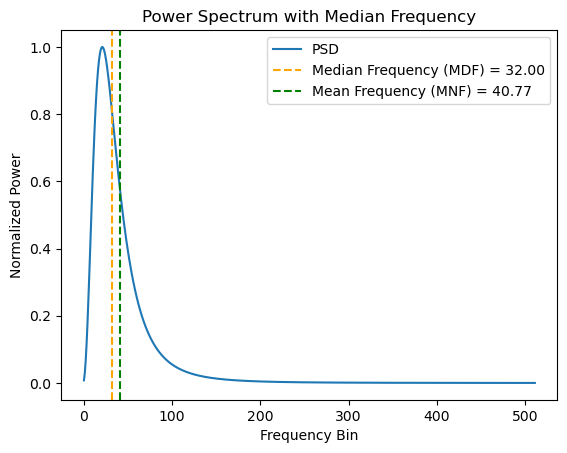

In [10]:
if mode == 'DeLuca':
    burst_1 = []
    #[filtro, Pdeluca, burst_1] = superlet.fdeluca(72, 110, 1024, burst_duration_1, plot = True)
    [filtro, Pdeluca, burst_1, MNF, MNF_analytic] = superlet.fdeluca(40, 20, fs, burst_duration_1, plot = False)
    f = np.arange(0, fs / 2)
    MNF_IDEAL = superlet.meanfreq(Pdeluca,f)
    MNF_1 = [MNF_IDEAL]
    t_onset_1 = burst_start_1
    t_offset_1 = burst_start_1 + burst_duration_1
    # bw = 100
    # nyquist = fs / 2
    # frec_baja = (MNF_1[0] - bw / 2) / nyquist
    # frec_alta = (MNF_1[0] + bw / 2) / nyquist
    # # Diseñar filtro paso banda Butterworth
    # b, a = signal.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    # burst_1 = signal.filtfilt(b, a, burst_1)

In [11]:
MNF

40.77148546557233

In [12]:
MNF_IDEAL

39.77148546557233

#### Add noise to the signal with a particular value for SNR

In [13]:
def add_noise(x, snr, plot = False):
    """
    Add Gaussian random noise to a signal with a specified SNR.

    Parameters:
        x (numpy array): Original signal (vector)
        snr (float): Desired Signal-to-Noise Ratio (in dB)

    Returns:
        numpy array: Signal with added Gaussian noise
    """
    n = len(x)  # Length of the signal
    Px = np.sum(np.abs(x)**2) / n  # Power of the original signal
    Pn = Px / (10**(snr / 10))  # Noise power for the given SNR

    noise = np.sqrt(Pn) * np.random.randn(*x.shape)  # Generate Gaussian noise
    xn = x + noise  # Add noise to the original signal

    # Plot the original and noisy signals
    if plot:
        plt.figure()
        plt.plot(xn, 'r', label='Noisy Signal')
        plt.plot(x, 'b', label='Original Signal')
        plt.legend()
        plt.title(f'Signal with Added White Gaussian Noise (SNR = {snr} dB)')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

    return xn

### We add burst to baseline signal

In [14]:
baseline_1 = noise.copy()
baseline_1[int(burst_start_1*fs):int(burst_start_1*fs + len(burst_1))] += burst_1

### Signal visualization

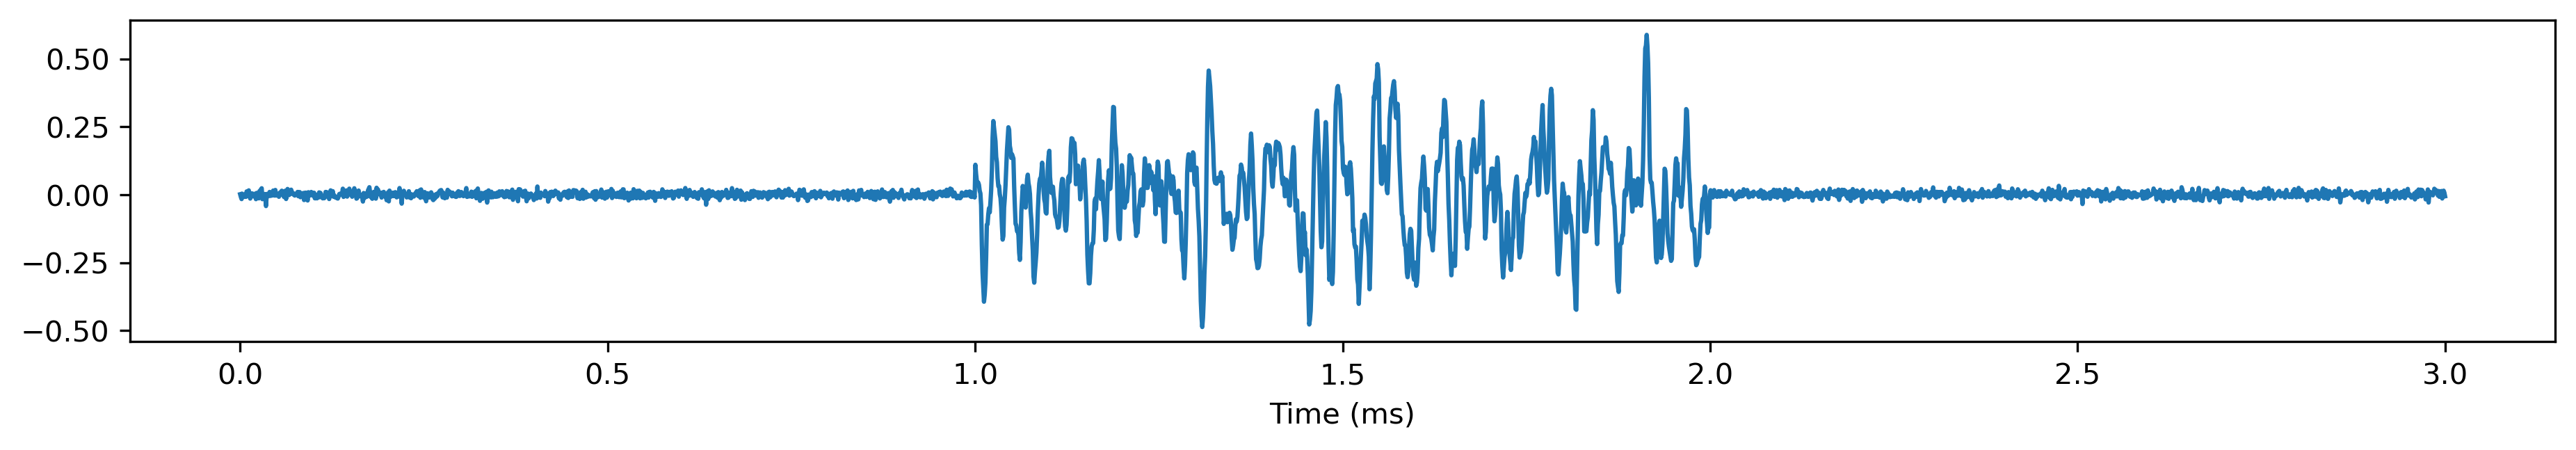

In [15]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal - np.mean(signal))/fs, len(signal - np.mean(signal))), signal - np.mean(signal))

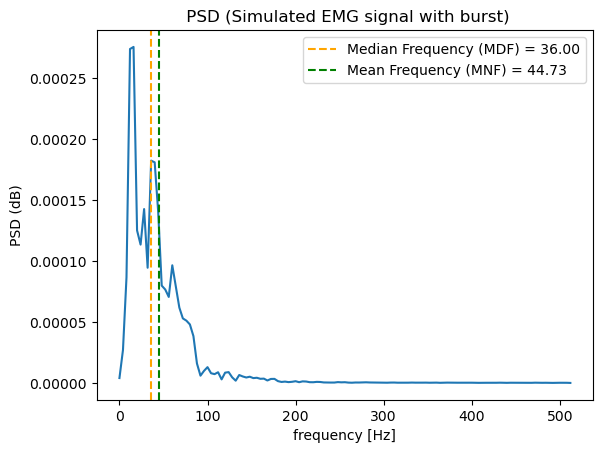

In [16]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal - np.mean(signal), fs, plot=True, muscle='Simulated EMG signal with burst')
MNF_1 = [MNF]

We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [17]:
MNF_1

[44.72585316395048]

In [18]:
def calculate_mae(estimates, true_value):
    # Convertir las estimaciones a un array de numpy
    estimates = np.array(estimates)
    
    # Si solo hay un valor verdadero, calcula el MAE de forma directa
    if np.isscalar(true_value) or len(true_value) == 1:
        errors = np.abs(estimates - true_value)
    else:
        # Si hay dos valores (inicio y final), calcula el MAE para ambos
        true_start, true_end = true_value
        start_errors = np.abs(estimates[:, 0] - true_start)
        end_errors = np.abs(estimates[:, 1] - true_end)
        errors = (start_errors + end_errors) / 2  # Promedio de los errores
        
    # Calcula el MAE y la desviación estándar
    mae = np.mean(errors)
    std_error = np.std(errors)
    return mae, std_error


In [19]:
freqs = np.linspace(20,500,int(fs/2)) # Número de puntos del vector frecuencia
freq_min = freqs[0]  # Minimum freq
freq_max = freqs[-1]  # Frecuencia máxima
num_freqs = len(freqs)  # Resolución del rango de frecuencias

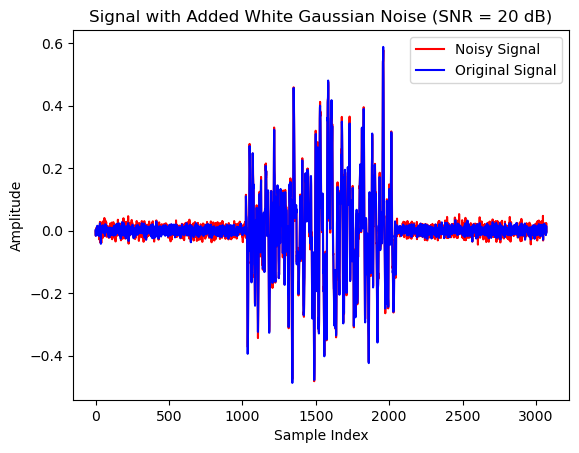

In [20]:
SNR = 20
if 'SNR' not in globals():
    SNR = "Inf"
    
signal_noise = add_noise(signal, SNR, plot = True)
signal = signal_noise

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [21]:
importlib.reload(morlet)

<module 'superlets_package.morlet' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/morlet.py'>

In [22]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [23]:
offset = 0 # Para que la figura del instant mean frequency sea más mona
offset_burst = 0

In [24]:
params_wavelet = [3, 16, 33, 55, 60]

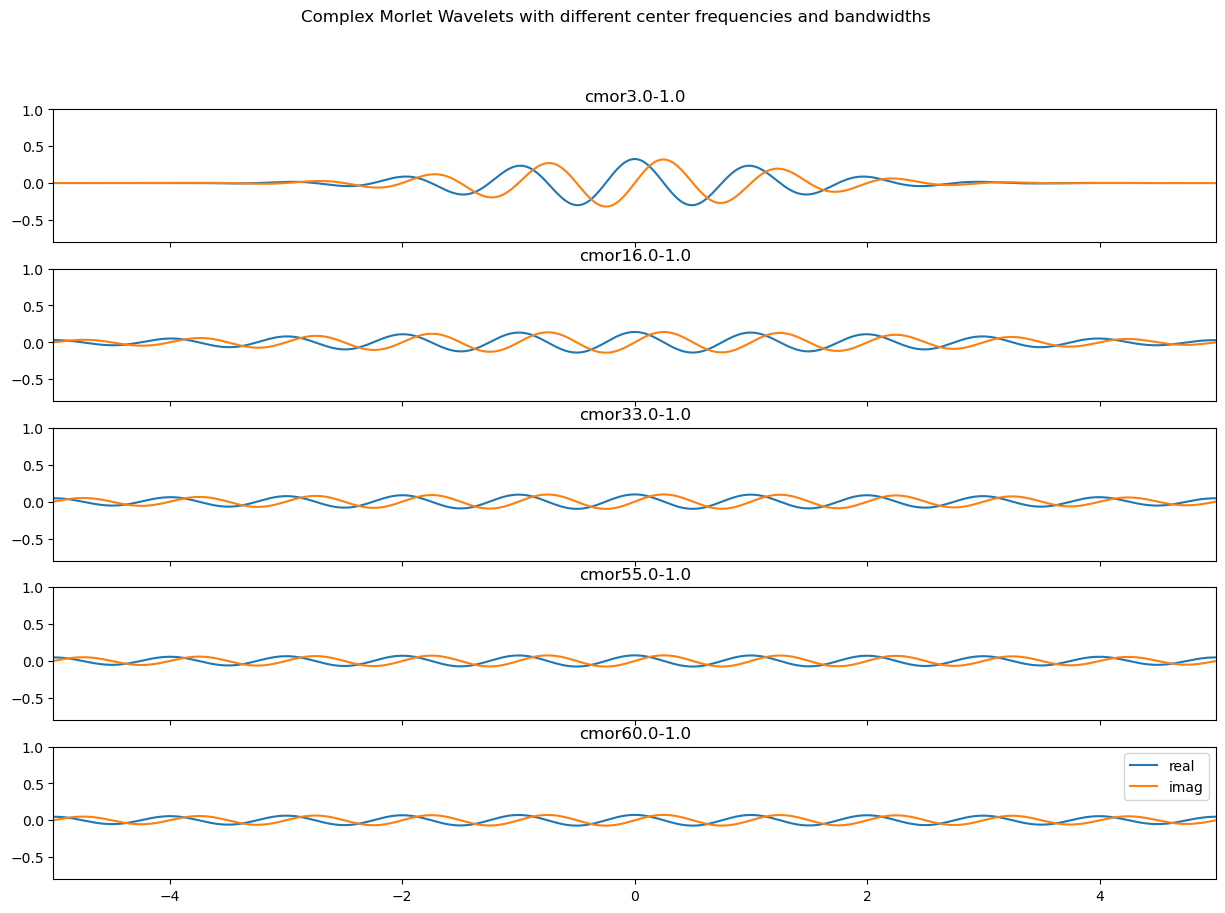

In [25]:
# Plot complex morlet wavelets with different center frequencies and bandwidths
import pywt
#wavelets = [f"cmor{x:.1f}-{y:.1f}" for x, y in zip(params_wavelet,[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])]
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x, y in zip(params_wavelet,[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])]
fig, axs = plt.subplots(len(params_wavelet), figsize=(15, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

In [26]:
MNF_1

[44.72585316395048]

In [27]:
folder_out = "/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/RESULTS"
new_folder_path = os.path.join(folder_out, str(round(MNF_1[0], 2)) + ' Hz')
os.makedirs(new_folder_path, exist_ok=True)

In [28]:
plot_1 = False
plot_2 = True
plot_means = True
save = False

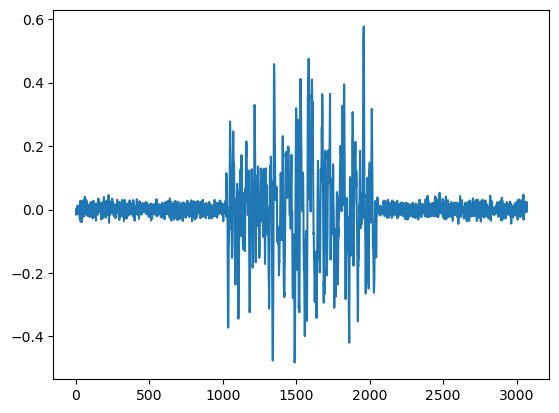

In [29]:
plt.plot(signal)

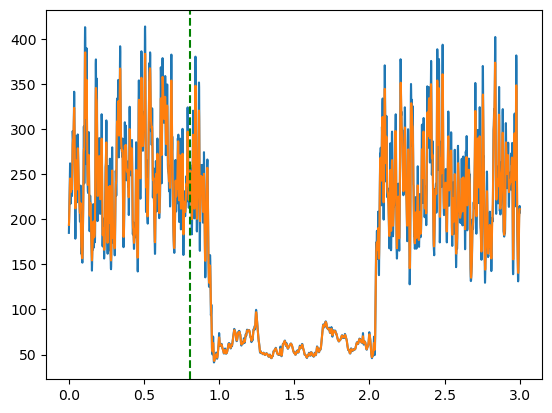

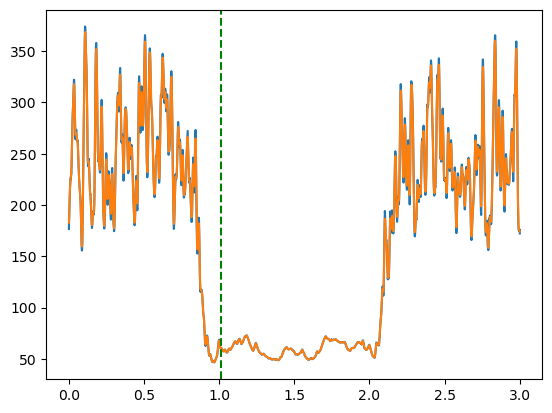

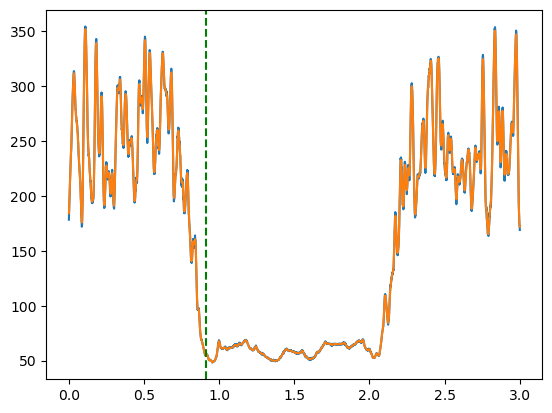

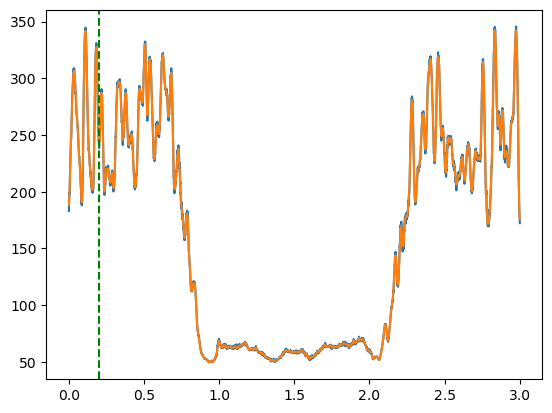

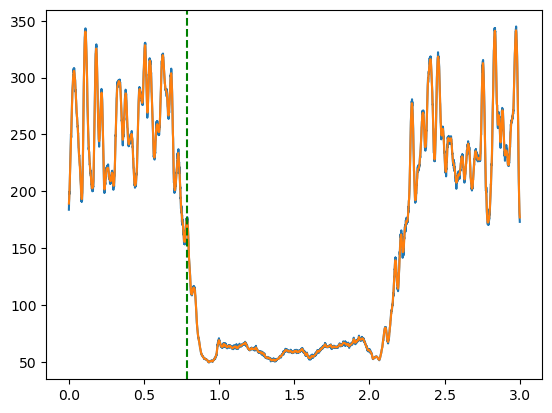

In [30]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
if plot_2:
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

# Iterar sobre los parámetros de wavelet
for i, c in enumerate(params_wavelet):
    wavelet = f"cmor{c}-1.0"
    
    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:, :])
    
    if save:
        df = pd.DataFrame(cwtmatr)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
    
    scalogram_2 = jnp.abs(cwtmatr)**2
    scalogram_2 = np.array(scalogram_2)
    
    #if np.any(np.isnan(scalogram_2)) or np.any(np.isinf(scalogram_2)):
    #scalogram_2 = np.nan_to_num(scalogram_2)

    if plot_1:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    # Para evitar la división por cero
    # denominador = np.sum(scalogram_2, axis=0)
    # denominador = np.where(denominador == 0, 1e-10, denominador)
    #instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / denominador
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    smoothed_signal = gaussian_filter1d(instant_freq, sigma=2)

    # Calcular la derivada para detectar la transición a la meseta
    derivative = np.gradient(smoothed_signal)
    
    # Definir un umbral para la estabilidad de la meseta
    threshold = np.percentile(np.abs(derivative), 1)  # Puedes ajustar este valor
    
    # Encontrar el primer punto donde la variación es baja (meseta detectada)
    indices = np.where(np.abs(derivative) < threshold)[0]

    t_onset = t[indices[0]]  # Primer punto de la meseta
    
    plt.figure()
    plt.plot(t,instant_freq)
    plt.plot(t,smoothed_signal)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    

In [31]:
    window_size = 100
    threshold = 4
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(new_time, np.gradient(media_movil), color='green')
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(std_total))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(new_time,std_total)
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    
# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

IndentationError: expected an indented block (2650265.py, line 95)

In [ ]:
new_time

In [ ]:
mae_wavelet_f

In [ ]:
mae_wavelet_t

There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [ ]:
importlib.reload(superlet)

In [ ]:
params_superlet = [[1, 1, 3, 5, 5], [3, 5, 1, 1, 1], [30, 40, 30, 40, 50]]

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path,str(SNR) + "dB_superlet_" + str(base_cycle) + "-" + str(min_order) + "-" + str(max_order) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados

    # if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
    #     scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    instant_mean_freq_total = []
    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]
    
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    
    window_size = 100
    threshold = 6
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(np.gradient(media_movil), color='green')
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(media_movil))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
     
    # start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    # end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final    

    initial_imnf = instant_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    if plot_2:
        ax_2[i].plot(t, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(t, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

     #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(std_total)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [ ]:
mae_superlet_f

In [ ]:
mae_superlet_t

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [ ]:
importlib.reload(superlet)

In [ ]:
offset_burst = 0
offset = 0

In [ ]:
from scipy.signal import stft
from scipy.signal import windows

windows_ms = [38, 200, 413, 550, 600]

if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))

    f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_1:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    #scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx)**2, nan=0.0, posinf=0.0, neginf=0.0)
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []   
    
    # Para evitar la división por cero
    denominador = np.sum(scalogram_2, axis=0)
    # denominador = np.where(denominador == 0, 1e-10, denominador)
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    
    window_size = 100
    threshold = 6
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(np.gradient(media_movil), color='green')
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(media_movil))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t_stft, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        ax_2[i].grid(True)

        ax_3.plot(t_stft, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(std_total)
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [ ]:
mae_stft_f

In [ ]:
mae_stft_t

### Plot comparison of the same SNR

# MAE IN FREQUENCY

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,1)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

In [ ]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Only first time!!!!

In [ ]:
MAES_f = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'std_stft': [],
    'std_wavelet': [],
    'std_superlet': []
}

In [ ]:
MAES_f['wavelet'].append(mae_wavelet_f)
MAES_f['stft'].append(mae_stft_f)
MAES_f['superlet'].append(mae_superlet_f)
MAES_f['std_wavelet'].append(std_wavelet_f)
MAES_f['std_stft'].append(std_stft_f)
MAES_f['std_superlet'].append(std_superlet_f)

In [ ]:
MAES_f

In [ ]:
MAES_t = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'std_stft': [],
    'std_wavelet': [],
    'std_superlet': []
}

In [ ]:
MAES_t['wavelet'].append(mae_wavelet_t)
MAES_t['stft'].append(mae_stft_t)
MAES_t['superlet'].append(mae_superlet_t)
MAES_t['std_wavelet'].append(std_wavelet_t)
MAES_t['std_stft'].append(std_stft_t)
MAES_t['std_superlet'].append(std_superlet_t)

In [ ]:
MAES_t

### WE REPEAT EVERYTHING WITH DIFFERENT SNR

## We reset the signal

# Baseline parameters

In [ ]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1[0]} Hz")

In [ ]:
SNR = 5
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot = True)
signal = signal_noise

In [ ]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [ ]:
importlib.reload(superlet)

In [ ]:
plot_1 = False
plot_2 = False

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

# Iterar sobre los parámetros de wavelet
for i, c in enumerate(params_wavelet):
    wavelet = f"cmor{c}-1.0"

    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:, :])
    
    if save:
        df = pd.DataFrame(cwtmatr)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
    
    scalogram_2 = jnp.abs(cwtmatr)**2

    if plot_1:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    
    window_size = 100
    threshold = 6
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(np.gradient(media_movil), color='green')
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(media_movil))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, media_movil)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(std_total, 'g-', label='Local slope (np.gradient)')
    plt.axvline(first_index, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(last_index, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [ ]:
mae_wavelet_f

In [ ]:
mae_wavelet_t

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [ ]:
importlib.reload(superlet)

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path,str(SNR) + "dB_superlet_" + str(base_cycle) + "-" + str(min_order) + "-" + str(max_order) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados

    instant_mean_freq_total = []
    total_scalogram_superlet.append(scalogram_2)
    
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    
    window_size = 100
    threshold = 6
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(np.gradient(media_movil), color='green')
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(media_movil))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final   

    initial_imnf = instant_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    if plot_2:
        ax_2[i].plot(t, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(t, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

     #MAE in frequency
    print(f'Estimated mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)
    
    # Visualización
    plt.figure(figsize=(12, 6))
    
    # Gráfica original
    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq, label='Datos originales')
    plt.axvline(t_onset, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(t_offset, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.title('Gráfica original y cálculo de pendientes')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    
    # Gráfica de pendientes
    plt.subplot(2, 1, 2)
    plt.plot(std_total, 'g-', label='Pendiente local (np.gradient)')
    plt.axvline(first_index, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(last_index, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [ ]:
mae_superlet_f

In [ ]:
mae_superlet_t

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [ ]:
importlib.reload(superlet)

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    
    f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_1:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []  
    
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    # valid = ~np.isnan(instant_freq)
    # t_valid = t[valid]
    # signal_valid = instant_freq[valid]
    # instant_freq = np.interp(t, t_valid, signal_valid)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(instant_freq)
    #     plt.title('Frecuencia instantánea')

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # window_size = 50
    # window = np.ones(window_size) / window_size  # Ventana normalizada
    # Calcular la media móvil con convolución
    # media_movil = np.convolve(instant_freq, window, mode='same')  
    # sigma = 10  # Desviación estándar del filtro PARA SNR = INF
    # media_movil = gaussian_filter1d(media_movil, sigma)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(media_movil, color = 'red')
    #     plt.title('Media de la señal')
    #     

    # # Derivada de la media para ver el cambio en el valor medio de la señal
    # slope_gradient = np.gradient(media_movil, t)
    # if plot_means:
    #     plt.figure()
    #     plt.plot(slope_gradient, color = 'green')
    #     plt.title('Gradiente de la media de la señal')
    # 
    # # Coger la porción de la señal del medio    
    # time_range = len(slope_gradient)//2
    # time_shift = round(burst_duration_1 * 0.6 * fs)
    # inicio = time_range-time_shift
    
    window_size = 100
    threshold = 6
    std_total = []
    first_index, last_index = None, None
    
    for i in range(len(instant_freq) - window_size):
        window = instant_freq[i:i + window_size]
        std_total.append(np.std(window))
    plt.figure()
    plt.plot(std_total)
    
    media_movil = np.convolve(std_total, window, mode='same')  
    plt.figure()
    plt.plot(np.gradient(media_movil), color='green')
    
    # Coger la porción de la señal del medio    
    time_range = len(instant_freq)//2
    time_shift = round(burst_duration_1 * 0.8 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(np.gradient(media_movil)[inicio:time_range]) + inicio
    last_index = np.argmax(np.gradient(media_movil)[time_range:time_range+time_shift]) + time_range 
    
    plt.axvline(first_index, color='green', linestyle='--', label='t_onset')
    plt.axvline(last_index, color='red', linestyle='--', label='t_offset')
    
    new_time = np.linspace(0, signal_duration, len(media_movil))
    t_onset = new_time[first_index]
    t_offset = new_time[last_index]
    
    start_idx = np.searchsorted(t_stft, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t_stft, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
   
    if plot_2:
        ax_2[i].plot(t_stft, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(t_stft, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    #MAE in frequency
    print(f'Estimated mean frequency = {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae([(t_onset,t_offset)], (t_onset_1,t_offset_1))
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(std_total, 'g-', label='Local slope (np.gradient)')
    plt.axvline(first_index, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(last_index, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [ ]:
mae_stft_f

In [ ]:
mae_stft_t

### Plot comparison of the same SNR

# MAE IN FREQUENCY

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,1)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

In [ ]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [ ]:
MAES_f

In [ ]:
MAES_f['wavelet'].append(mae_wavelet_f)
MAES_f['stft'].append(mae_stft_f)
MAES_f['superlet'].append(mae_superlet_f)
MAES_f['std_wavelet'].append(std_wavelet_f)
MAES_f['std_stft'].append(std_stft_f)
MAES_f['std_superlet'].append(std_superlet_f)

In [ ]:
MAES_t

In [ ]:
MAES_t['wavelet'].append(mae_wavelet_t)
MAES_t['stft'].append(mae_stft_t)
MAES_t['superlet'].append(mae_superlet_t)
MAES_t['std_wavelet'].append(std_wavelet_t)
MAES_t['std_stft'].append(std_stft_t)
MAES_t['std_superlet'].append(std_superlet_t)

In [ ]:
MAES_t

### COMPARISON BETWEEN ALL SNR

# COMPARISON OF MAE IN FREQUENCY

In [ ]:
params_wavelet = params_wavelet
params_superlet = params_superlet
params_stft = windows_ms  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES_f['stft']
std_stft = MAES_f['std_stft']

mae_wavelet = MAES_f['wavelet']
std_wavelet = MAES_f['std_wavelet']

mae_superlet = MAES_f['superlet']
std_superlet = MAES_f['std_superlet']

# Reordenar los niveles de SNR al orden deseado: 5 dB, 20 dB, Sin SNR
snr_labels = ["5 dB", "20 dB"]
mae_stft_2 = [mae_stft[1], mae_stft[0]]
std_stft_2 = [std_stft[1], std_stft[0]]

mae_wavelet_2 = [mae_wavelet[1], mae_wavelet[0]]
std_wavelet_2 = [std_wavelet[1], std_wavelet[0]]

mae_superlet_2 = [mae_superlet[1], mae_superlet[0]]
std_superlet_2 = [std_superlet[1], std_superlet[0]]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros
num_snr = len(snr_labels)  # Número de niveles de ruido
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Tonalidades por nivel de ruido (ordenadas)
tonalidades = {
    "5 dB": 0.4,
    "20 dB": 0.6,
}

# Colores base por metodología (asegurando correspondencia)
colores_base = {
    "STFT": plt.colormaps["Blues"],
    "Wavelet": plt.colormaps["Greens"],
    "Superlet": plt.colormaps["Oranges"],
}

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Crear listas para la leyenda
handles = []
labels_legend = []

# Dibujar barras para cada técnica y SNR
for i, snr in enumerate(snr_labels):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    bar = plt.bar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["STFT"](tonalidades[snr]),
        label=f'STFT ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_stft_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )
    
    # Dibujar barras para Wavelet
    bar = plt.bar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Wavelet"](tonalidades[snr]),
        label=f'Wavelet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_wavelet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

    # Dibujar barras para Superlet
    bar = plt.bar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Superlet"](tonalidades[snr]),
        label=f'Superlet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_superlet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

# Ordenar la leyenda agrupada por metodología
labels_legend = [f'STFT ({snr})' for snr in snr_labels] + \
                [f'Wavelet ({snr})' for snr in snr_labels] + \
                [f'Superlet ({snr})' for snr in snr_labels]
handles = handles[:len(labels_legend)]

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\n\nc={p_wavelet}\n\n\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('MAE (Hz)', fontsize=14)
plt.ylim(0, 100)
#plt.legend(handles, labels_legend, fontsize=10, ncol=1)  # Leyenda agrupada
plt.tight_layout()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
MAES_f

# COMPARISON OF MAE IN TIME

In [ ]:
MAES_t

In [ ]:
params_wavelet = params_wavelet
params_superlet = params_superlet
params_stft = windows_ms  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES_t['stft']
std_stft = MAES_t['std_stft']

mae_wavelet = MAES_t['wavelet']
std_wavelet = MAES_t['std_wavelet']

mae_superlet = MAES_t['superlet']
std_superlet = MAES_t['std_superlet']

# Reordenar los niveles de SNR al orden deseado: 5 dB, 20 dB, Sin SNR
snr_labels = ["5 dB", "20 dB"]
mae_stft_2 = [mae_stft[1], mae_stft[0]]
std_stft_2 = [std_stft[1], std_stft[0]]

mae_wavelet_2 = [mae_wavelet[1], mae_wavelet[0]]
std_wavelet_2 = [std_wavelet[1], std_wavelet[0]]

mae_superlet_2 = [mae_superlet[1], mae_superlet[0]]
std_superlet_2 = [std_superlet[1], std_superlet[0]]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros
num_snr = len(snr_labels)  # Número de niveles de ruido
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Tonalidades por nivel de ruido (ordenadas)
tonalidades = {
    "5 dB": 0.4,
    "20 dB": 0.6,
}

# Colores base por metodología (asegurando correspondencia)
colores_base = {
    "STFT": plt.colormaps["Blues"],
    "Wavelet": plt.colormaps["Greens"],
    "Superlet": plt.colormaps["Oranges"],
}

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Crear listas para la leyenda
handles = []
labels_legend = []

# Dibujar barras para cada técnica y SNR
for i, snr in enumerate(snr_labels):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    bar = plt.bar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["STFT"](tonalidades[snr]),
        label=f'STFT ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_stft_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )
    
    # Dibujar barras para Wavelet
    bar = plt.bar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Wavelet"](tonalidades[snr]),
        label=f'Wavelet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_wavelet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

    # Dibujar barras para Superlet
    bar = plt.bar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Superlet"](tonalidades[snr]),
        label=f'Superlet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_superlet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

# Ordenar la leyenda agrupada por metodología
labels_legend = [f'STFT ({snr})' for snr in snr_labels] + \
                [f'Wavelet ({snr})' for snr in snr_labels] + \
                [f'Superlet ({snr})' for snr in snr_labels]
handles = handles[:len(labels_legend)]

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\n\nc={p_wavelet}\n\n\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.yticks(np.arange(0, 0.61, 0.1))
plt.ylabel('MAE (Hz)', fontsize=14)
plt.ylim(0, 0.6)
#plt.legend(handles, labels_legend, fontsize=10, ncol=1)  # Leyenda agrupada
plt.tight_layout()
plt.grid(True)

# Mostrar el gráfico
plt.show()